<a href="https://colab.research.google.com/github/lzocro/-Papers/blob/master/DL_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning assignment 1

## Definitions

In [2]:

import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np

###Keras stuff
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, advanced_activations, Flatten, Conv2D, MaxPooling2D, Flatten, Input, UpSampling2D, merge
from keras.utils import np_utils
from keras.optimizers import SGD, Adam
from keras.layers.normalization import BatchNormalization
from keras import regularizers
# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

Using TensorFlow backend.


In [0]:
def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

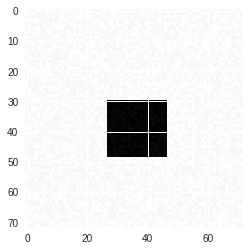

In [4]:
im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

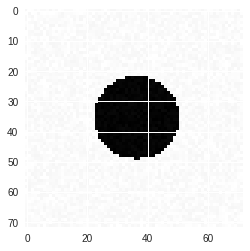

In [5]:
im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

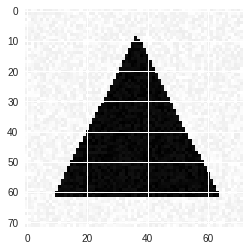

In [6]:
[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

In [0]:
import matplotlib.patches as patches

def visualize_prediction(x, y, nr, nc):
    fig, axarr = plt.subplots(figsize=(18, 16),nrows=nr,ncols=nc)
    index=0
    for i in range(nr):
        for j in range(nc):
            I = x[index].reshape((IMAGE_SIZE,IMAGE_SIZE))
            axarr[i,j].imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
            axarr[i,j].set_xlim([0,1])
            axarr[i,j].set_ylim([0,1])
            axarr[i,j].grid(False)
            axarr[i,j].set_xticks([])
            axarr[i,j].set_yticks([])
            xy = y[index].reshape(3,2)
            tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
            axarr[i,j].add_patch(tri)
            index+=1
    #return(ax)
    plt.show()

## A Simple Classification Task


Here we generate some data.

In [8]:
[X_train, Y_train] = generate_dataset_classification(400, 20)
Y_train=np_utils.to_categorical(Y_train,3)
X_train=X_train.reshape((X_train.shape[0],72,72))
X_train=np.expand_dims(X_train, axis=-1)

Creating data:


A simple perceptron with SGD appears to never reach the optimum value, and often gets stuck in a local minimum of around two thirds accuracy. This was consistent regardless of the number of neurons, and the loss chosen. Although 16 neurons and binary corssentropy yielded the best results. 

In [10]:
model = Sequential()
model.add(Dense(16, activation='relu', input_shape =(72,72,1)))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
sgd=SGD(lr=0.01,decay=1e-6,momentum=0.9,nesterov=True)
model.compile(loss='binary_crossentropy',optimizer=sgd,metrics=['accuracy'])
model.fit(X_train,Y_train, batch_size=32,validation_split=0.25,epochs=10,verbose=1)

Train on 300 samples, validate on 100 samples
Epoch 1/10
300/300 [==============================] - 0s 1ms/step - loss: 2.5279 - acc: 0.6122 - val_loss: 0.6370 - val_acc: 0.6667
Epoch 2/10
300/300 [==============================] - 0s 448us/step - loss: 0.6371 - acc: 0.6667 - val_loss: 0.6369 - val_acc: 0.6667
Epoch 3/10
300/300 [==============================] - 0s 443us/step - loss: 0.6370 - acc: 0.6667 - val_loss: 0.6369 - val_acc: 0.6667
Epoch 4/10
300/300 [==============================] - 0s 440us/step - loss: 0.6369 - acc: 0.6667 - val_loss: 0.6366 - val_acc: 0.6667
Epoch 5/10
300/300 [==============================] - 0s 440us/step - loss: 0.6365 - acc: 0.6667 - val_loss: 0.6366 - val_acc: 0.6667
Epoch 6/10
300/300 [==============================] - 0s 440us/step - loss: 0.6365 - acc: 0.6667 - val_loss: 0.6364 - val_acc: 0.6667
Epoch 7/10
300/300 [==============================] - 0s 449us/step - loss: 0.6364 - acc: 0.6667 - val_loss: 0.6363 - val_acc: 0.6667
Epoch 8/10
300/300

The best model to come out of our experiments is the following one, a 2 layer perceptron, with 16 input neurons, with rectified linear units activation and a binary crossentropy target with the Adam optimiser. It consistently reaches 0.75 accuracy and was often recorded at 1 after 20 epochs with 32 samples per batch.  Adam yielded better results overall, and will be used throughout, with tweaks to the learning rate later on.

In [12]:
model = Sequential()
model.add(Dense(16, activation='relu', input_shape =(72,72,1)))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])
model.fit(X_train,Y_train,batch_size=32,validation_split=0.06,epochs=20,verbose=1)

Train on 376 samples, validate on 24 samples
Epoch 1/20
376/376 [==============================] - 0s 1ms/step - loss: 1.4096 - acc: 0.6312 - val_loss: 0.3679 - val_acc: 0.8611
Epoch 2/20
376/376 [==============================] - 0s 407us/step - loss: 0.4978 - acc: 0.7881 - val_loss: 0.7312 - val_acc: 0.6389
Epoch 3/20
376/376 [==============================] - 0s 397us/step - loss: 0.3377 - acc: 0.8413 - val_loss: 0.1932 - val_acc: 0.9722
Epoch 4/20
376/376 [==============================] - 0s 399us/step - loss: 0.1976 - acc: 0.9291 - val_loss: 0.1467 - val_acc: 1.0000
Epoch 5/20
376/376 [==============================] - 0s 420us/step - loss: 0.1637 - acc: 0.9424 - val_loss: 0.2988 - val_acc: 0.8056
Epoch 6/20
376/376 [==============================] - 0s 404us/step - loss: 0.1564 - acc: 0.9504 - val_loss: 0.1496 - val_acc: 0.9722
Epoch 7/20
376/376 [==============================] - 0s 397us/step - loss: 0.1030 - acc: 0.9770 - val_loss: 0.0890 - val_acc: 1.0000
Epoch 8/20
376/376 

In [13]:
X_test = generate_a_disk()
X_test = X_test.reshape(1,72,72,1)
model.predict(X_test)

array([[0., 1., 0.]], dtype=float32)

The Weights show any interesting features but do not appear to show any interpretable features. We can notice they focus on the center band on the image, and seem to have some periodicity.

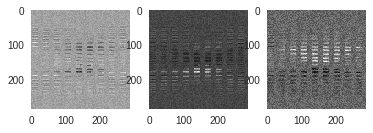

In [14]:
weights=model.get_weights()

#print(weights)
fig,(ax1,ax2,ax3)=plt.subplots(nrows=1,ncols=3)
ax1.grid(False)
ax2.grid(False)
ax3.grid(False)
ax1.imshow(weights[2].reshape((288,288,3))[:,:,0],cmap='gray')
ax2.imshow(weights[2].reshape((288,288,3))[:,:,1],cmap='gray')
ax3.imshow(weights[2].reshape((288,288,3))[:,:,2],cmap='gray')
plt.show()

## A More Complex Classification Task


### Simple Model

First we generate a large dataset, with noise and movement.

In [15]:
[X_train, Y_train] = generate_dataset_classification(3000, 20, True)
Y_train=np_utils.to_categorical(Y_train,3)
X_train=X_train.reshape((X_train.shape[0],72,72))
X_train=np.expand_dims(X_train, axis=-1)

Creating data:


Now we train our previous classifier (the second one from part 1.2) on this data. Training accuracy is correct, around 0.75.

In [16]:
model.fit(X_train,Y_train,batch_size=32,validation_split=0.1,epochs=20,verbose=1)

Train on 2700 samples, validate on 300 samples
Epoch 1/20
2700/2700 [==============================] - 1s 424us/step - loss: 0.9767 - acc: 0.6532 - val_loss: 0.5752 - val_acc: 0.6833
Epoch 2/20
2700/2700 [==============================] - 1s 415us/step - loss: 0.5346 - acc: 0.7151 - val_loss: 0.6311 - val_acc: 0.6967
Epoch 3/20
2700/2700 [==============================] - 1s 420us/step - loss: 0.5070 - acc: 0.7320 - val_loss: 0.5212 - val_acc: 0.7267
Epoch 4/20
2700/2700 [==============================] - 1s 418us/step - loss: 0.5015 - acc: 0.7357 - val_loss: 0.5406 - val_acc: 0.7244
Epoch 5/20
2700/2700 [==============================] - 1s 411us/step - loss: 0.4807 - acc: 0.7484 - val_loss: 0.5051 - val_acc: 0.7356
Epoch 6/20
2700/2700 [==============================] - 1s 406us/step - loss: 0.4853 - acc: 0.7417 - val_loss: 0.5522 - val_acc: 0.7411
Epoch 7/20
2700/2700 [==============================] - 1s 405us/step - loss: 0.5014 - acc: 0.7400 - val_loss: 0.5540 - val_acc: 0.6867
E

Moving on to testing data, we note a performance very comparable to the one in the training dataset, around 0.75.

In [17]:
[X_test, Y_test] = generate_test_set_classification()
#Y_test=np_utils.to_categorical(Y_test,3) already done by the function
X_test=X_test.reshape((X_test.shape[0],72,72))
X_test=np.expand_dims(X_test, axis=-1)

Creating data:


In [18]:
model.evaluate(X_test, Y_test,verbose=1)

300/300 [==============================] - 0s 189us/step


[0.4941056458155314, 0.7566666944821676]

### A Convolutional Neural Network classifier


#### Convolutional network 1 


A simple convolutional network composed of 1 convolutional layer with 16 5×5 filters, 1 pooling layer, and one fully connected layer. Optimising binary corssentropy with sgd gives training accuracy around 0.9 after 10 epochs, which rises to 0.97 after 20, but this does not propagate to the test set, indicating over-fitting.  

In [19]:
model=Sequential()
########
model.add(Conv2D(16, (5,5), activation='relu', input_shape =(72,72,1)))
########
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
########
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
########
model.add(Dense(3,activation='softmax'))
########
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
########
model.fit(X_train, Y_train, batch_size=32,validation_split=0.1, epochs=100, verbose=1)

Train on 2700 samples, validate on 300 samples
Epoch 1/100
2700/2700 [==============================] - 3s 1ms/step - loss: 0.5954 - acc: 0.6880 - val_loss: 0.5064 - val_acc: 0.7389
Epoch 2/100
2700/2700 [==============================] - 1s 381us/step - loss: 0.4564 - acc: 0.7678 - val_loss: 0.4510 - val_acc: 0.7656
Epoch 3/100
2700/2700 [==============================] - 1s 387us/step - loss: 0.4060 - acc: 0.7994 - val_loss: 0.4328 - val_acc: 0.7867
Epoch 4/100
2700/2700 [==============================] - 1s 382us/step - loss: 0.3698 - acc: 0.8268 - val_loss: 0.3978 - val_acc: 0.8189
Epoch 5/100
2700/2700 [==============================] - 1s 385us/step - loss: 0.3306 - acc: 0.8611 - val_loss: 0.3754 - val_acc: 0.8178
Epoch 6/100
2700/2700 [==============================] - 1s 385us/step - loss: 0.2961 - acc: 0.8798 - val_loss: 0.3431 - val_acc: 0.8733
Epoch 7/100
2700/2700 [==============================] - 1s 389us/step - loss: 0.2628 - acc: 0.8948 - val_loss: 0.3275 - val_acc: 0.8

One can observe the test values stay around 0.95.

In [20]:
model.evaluate(X_test, Y_test,verbose=1)

300/300 [==============================] - 0s 163us/step


[0.2198470910390218, 0.9411111251513163]

#### Convolutional network 2


Let's attempt to use a heavier network to improve the scores. We take a Convolution layer with 32 5x5 filters, maxpooling and dropout, a dense hidden layer with 128 neurons and Adam as our optimizer for binary crossentropy. This yields sizeable improvements, but at a large training time cost. Validation and test accuracy is also around 0.95. 

In [21]:
model=Sequential()
########
model.add(Conv2D(32, (5,5), activation='relu', input_shape =(72,72,1)))
########
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
########
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
########
model.add(Dense(3,activation='softmax'))
########
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
########
History = model.fit(X_train, Y_train, validation_split=0.1, batch_size=32, epochs=100, verbose=1)

Train on 2700 samples, validate on 300 samples
Epoch 1/100
2700/2700 [==============================] - 3s 970us/step - loss: 0.7512 - acc: 0.7169 - val_loss: 0.4573 - val_acc: 0.7733
Epoch 2/100
2700/2700 [==============================] - 2s 586us/step - loss: 0.3988 - acc: 0.8086 - val_loss: 0.3956 - val_acc: 0.8011
Epoch 3/100
2700/2700 [==============================] - 2s 577us/step - loss: 0.3308 - acc: 0.8585 - val_loss: 0.3176 - val_acc: 0.8878
Epoch 4/100
2700/2700 [==============================] - 1s 554us/step - loss: 0.2596 - acc: 0.9041 - val_loss: 0.2669 - val_acc: 0.9133
Epoch 5/100
2700/2700 [==============================] - 1s 551us/step - loss: 0.1920 - acc: 0.9377 - val_loss: 0.2637 - val_acc: 0.8800
Epoch 6/100
2700/2700 [==============================] - 2s 562us/step - loss: 0.1637 - acc: 0.9456 - val_loss: 0.1634 - val_acc: 0.9411
Epoch 7/100
2700/2700 [==============================] - 2s 583us/step - loss: 0.1125 - acc: 0.9654 - val_loss: 0.1383 - val_acc: 0

In [23]:
model.evaluate(X_test, Y_test,verbose=1)

300/300 [==============================] - 0s 182us/step


[0.23112236817677817, 0.9511111378669739]

The following plot presents a clear illustration of the learning quality of our network.

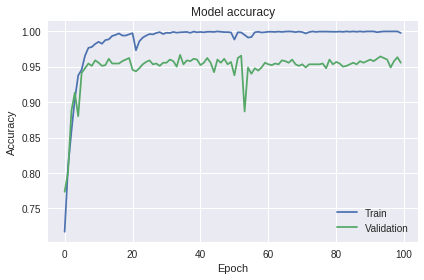

In [22]:
fig,ax=plt.subplots()
ax.set_axisbelow(True)
#ax.grid(True,which='both',ls=':',color='Gainsboro')
########
ax.plot(History.history['acc'], marker='', label="Train")
ax.plot(History.history['val_acc'], marker='', label="Validation")
########
ax.set_xlabel(r'Epoch')
ax.set_ylabel(r'Accuracy')
ax.set_title(r'Model accuracy')
plt.legend()
fig.tight_layout()
plt.show()
########

## Regression on the vertices of the triangle

#### A First attempt network

We begin with some data generation.

In [24]:
[X_train,Y_train]=generate_dataset_regression(3000,20)
X_train=X_train.reshape((X_train.shape[0],72,72))
X_train=np.expand_dims(X_train, axis=-1)

Creating data:


Here we turn the data into a vectors of length 6 made of 3 tuples (the vertices) sorted by their first component. This normalisation should make the labelling of each triangle unique, and no longer invariant under permutation as it is if we only predict where the summits are. 

In [0]:
def Ysort(Y):
    for y in range(Y.shape[0]):
        y1=Y[y][0:2]
        y2=Y[y][2:4]
        y3=Y[y][4:6]
        Y[y]=[element for tupl in sorted([y1,y2,y3], key=lambda x: x[0]) for element in tupl]
    return(Y)

Y_train=Ysort(Y_train)

We begin by repurposing the network from the previous question (note we changed the loss to mean squared error for regression) for use with this regression task, using a large dataset. The results are disapointing with a normal learning rate, but they were encouraging with one of the order $10^{-3}$ so we attempt to lower it even more and simply stack large amounts of epochs. The results are encouraging.

In [26]:
model=Sequential()
########
model.add(Conv2D(32, (5,5), activation='relu', input_shape =(72,72,1)))
########
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
########
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
########
model.add(Dense(6,activation='relu'))
########
adam=Adam(0.0005)
model.compile(loss='mse', optimizer=adam, metrics=['mae'])
########
History = model.fit(X_train, Y_train, validation_split=0.03, batch_size=32, epochs=500, verbose=1)

Train on 2910 samples, validate on 90 samples
Epoch 1/500
2910/2910 [==============================] - 3s 882us/step - loss: 0.3167 - mean_absolute_error: 0.4186 - val_loss: 0.2069 - val_mean_absolute_error: 0.3756
Epoch 2/500
2910/2910 [==============================] - 2s 557us/step - loss: 0.1967 - mean_absolute_error: 0.3603 - val_loss: 0.1798 - val_mean_absolute_error: 0.3526
Epoch 3/500
2910/2910 [==============================] - 2s 568us/step - loss: 0.1546 - mean_absolute_error: 0.3112 - val_loss: 0.1036 - val_mean_absolute_error: 0.2639
Epoch 4/500
2910/2910 [==============================] - 2s 559us/step - loss: 0.1335 - mean_absolute_error: 0.2889 - val_loss: 0.0657 - val_mean_absolute_error: 0.2136
Epoch 5/500
2910/2910 [==============================] - 2s 544us/step - loss: 0.1127 - mean_absolute_error: 0.2646 - val_loss: 0.0871 - val_mean_absolute_error: 0.2447
Epoch 6/500
2910/2910 [==============================] - 2s 560us/step - loss: 0.1010 - mean_absolute_error: 

Evaluating on a test set gives similar performance.

In [27]:
[X_test, Y_test] = generate_test_set_regression()
X_test=X_test.reshape((X_test.shape[0],72,72))
X_test=np.expand_dims(X_test, axis=-1)
Y_test=Ysort(Y_test)

Creating data:


In [28]:
model.evaluate(X_test, Y_test,verbose=1)

300/300 [==============================] - 0s 199us/step


[0.01078248751660188, 0.07047920972108841]

Plotting convergence we observe interesting step behaviour, and we appear to have moved outside the regime where this occurs, and our model barely improves its validation loss after 100 epochs, although it does not seem to suffer from overfitting even when its training continues, as the validation loss stays constant.

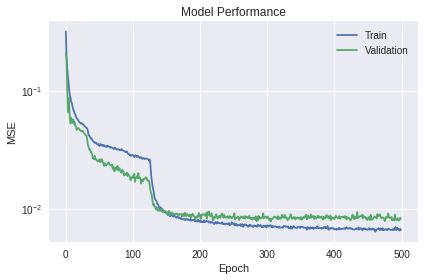

In [29]:
fig,ax=plt.subplots()
ax.set_axisbelow(True)
########
ax.plot(History.history['loss'], marker='', label="Train")
ax.plot(History.history['val_loss'], marker='', label="Validation")
########
ax.set_xlabel(r'Epoch')
ax.set_ylabel(r'MSE')
ax.set_yscale('log')
ax.set_title(r'Model Performance')
plt.legend()
fig.tight_layout()
plt.show()

This is what training predictions look like, not bad at all. This confirms the network is learning. 

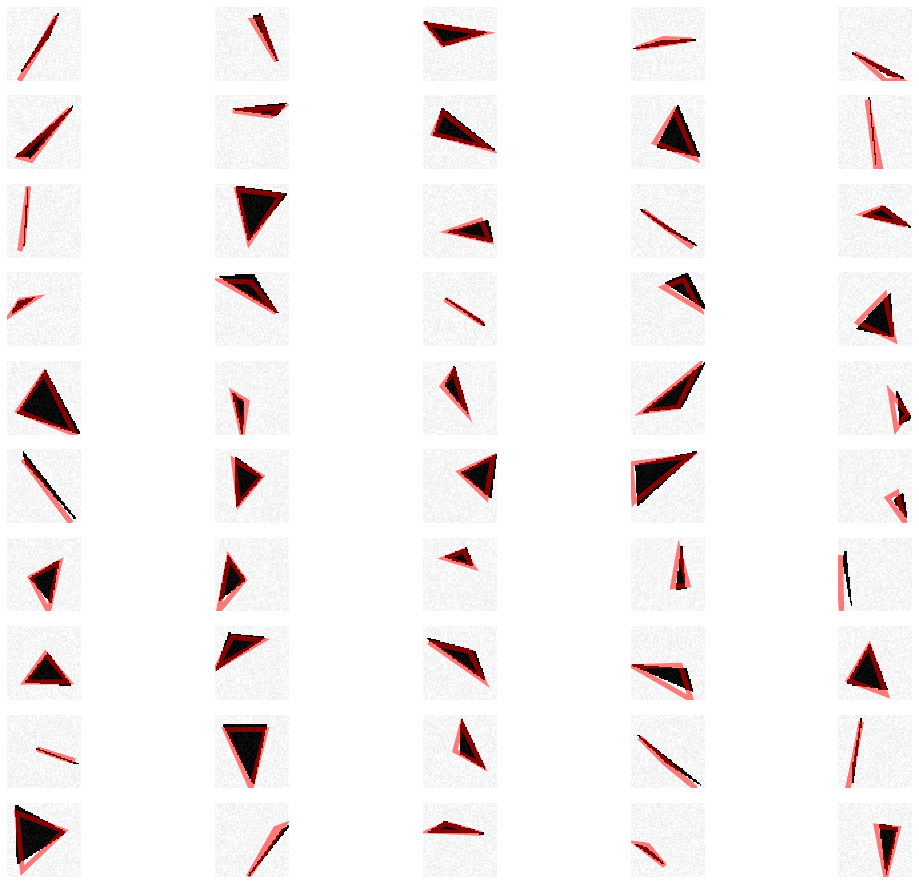

In [30]:
Y_pred=model.predict(X_train)
visualize_prediction(X_train[0:51], Y_pred[0:51],nr=10,nc=5)

These are the results on a test set. Slightly less impressive when it comes to larger triangles.

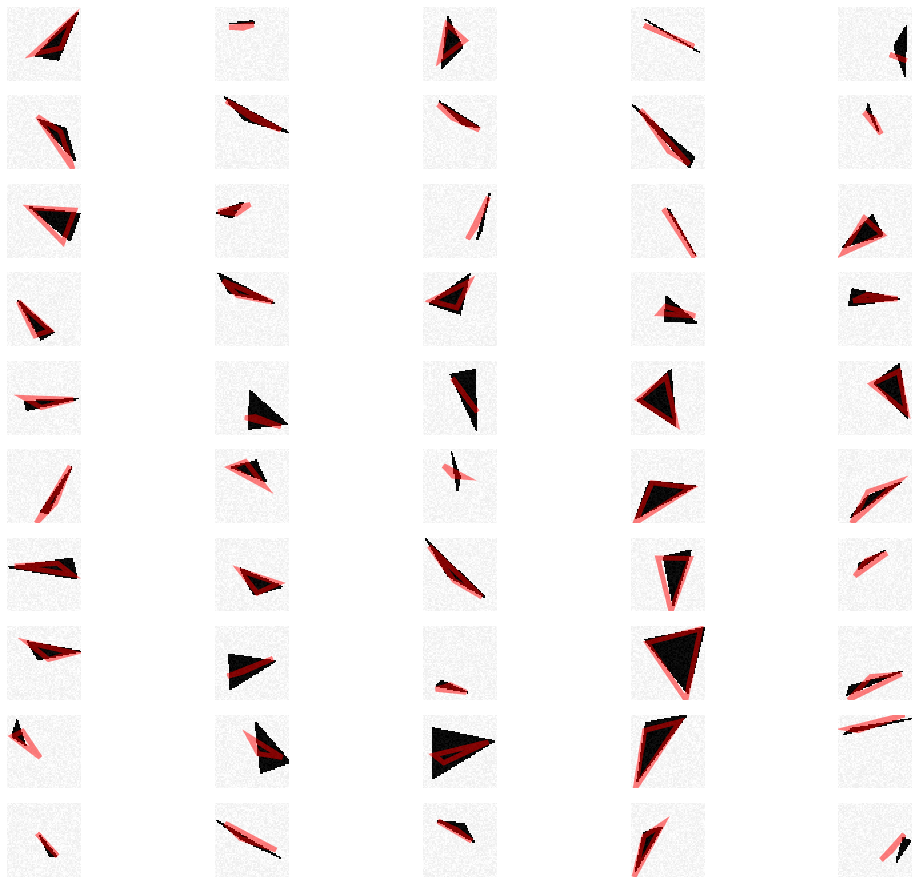

In [31]:
Y_pred=model.predict(X_test)
visualize_prediction(X_test[0:51], Y_pred[0:51],nr=10,nc=5)

#### A second attempt network

The previous network faired well but it still fails to appropriately identify some triangles in the test set, perhaps this can be resolved by stacking several convolution layers, so that the network can reason at larger scales from aggregated filters. We keep our slow learning rate adam from the previous network.

In [32]:
model=Sequential()
########
model.add(Conv2D(64, (3,3), activation='relu', input_shape =(72,72,1)))
########
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.1))
########
model.add(Conv2D(32, (3,3), activation='relu',))
########
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.1))
########
model.add(Conv2D(32, (3,3), activation='relu',))
########
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))
########
model.add(Conv2D(16, (3,3), activation='relu',))
########
model.add(Flatten())
model.add(Dense(6))
########
model.compile(loss='mean_squared_error', optimizer=adam)
########
History = model.fit(X_train, Y_train, validation_split=0.03, batch_size=32, epochs=500, verbose=1)

Train on 2910 samples, validate on 90 samples
Epoch 1/500
2910/2910 [==============================] - 3s 997us/step - loss: 0.0653 - val_loss: 0.0444
Epoch 2/500
2910/2910 [==============================] - 2s 677us/step - loss: 0.0339 - val_loss: 0.0325
Epoch 3/500
2910/2910 [==============================] - 2s 679us/step - loss: 0.0260 - val_loss: 0.0279
Epoch 4/500
2910/2910 [==============================] - 2s 679us/step - loss: 0.0216 - val_loss: 0.0190
Epoch 5/500
2910/2910 [==============================] - 2s 684us/step - loss: 0.0179 - val_loss: 0.0156
Epoch 6/500
2910/2910 [==============================] - 2s 682us/step - loss: 0.0157 - val_loss: 0.0137
Epoch 7/500
2910/2910 [==============================] - 2s 684us/step - loss: 0.0139 - val_loss: 0.0116
Epoch 8/500
2910/2910 [==============================] - 2s 689us/step - loss: 0.0129 - val_loss: 0.0125
Epoch 9/500
2910/2910 [==============================] - 2s 684us/step - loss: 0.0120 - val_loss: 0.0109
Epoch 10/

Plotting the convergeance, we can see a very different behaviour from in the previous model, but it slowly increases in quality after the initial 100 epochs. 

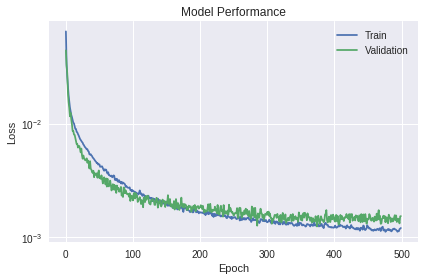

In [33]:
fig,ax=plt.subplots()
ax.set_axisbelow(True)
########
ax.plot(History.history['loss'], marker='', label="Train")
ax.plot(History.history['val_loss'], marker='', label="Validation")
########
ax.set_xlabel(r'Epoch')
ax.set_ylabel(r'Loss')
ax.set_yscale('log')
ax.set_title(r'Model Performance')
plt.legend()
fig.tight_layout()
plt.show()
########

Evaluating on the trian set shows the network has near-flawlessly learnt to understant its training data.

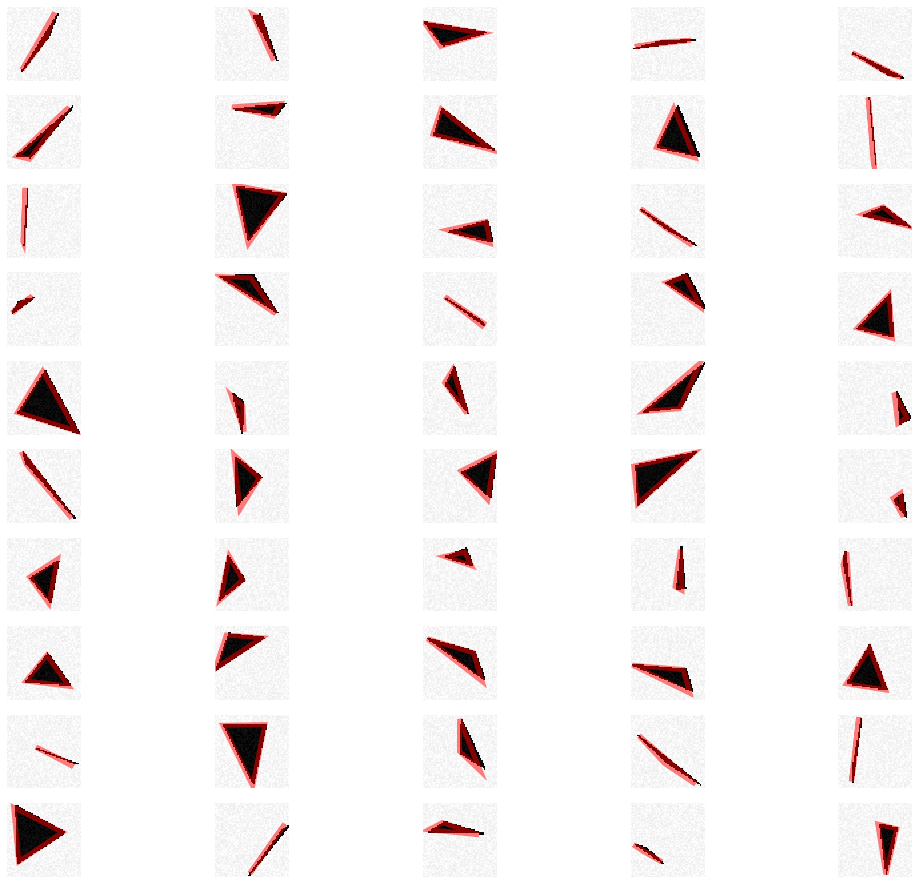

In [34]:
Y_pred=model.predict(X_train)
visualize_prediction(X_train[0:51], Y_pred[0:51],nr=10,nc=5)


On the test set we can see very good performance, although the return on investment for the increased complexity isn't very large. 

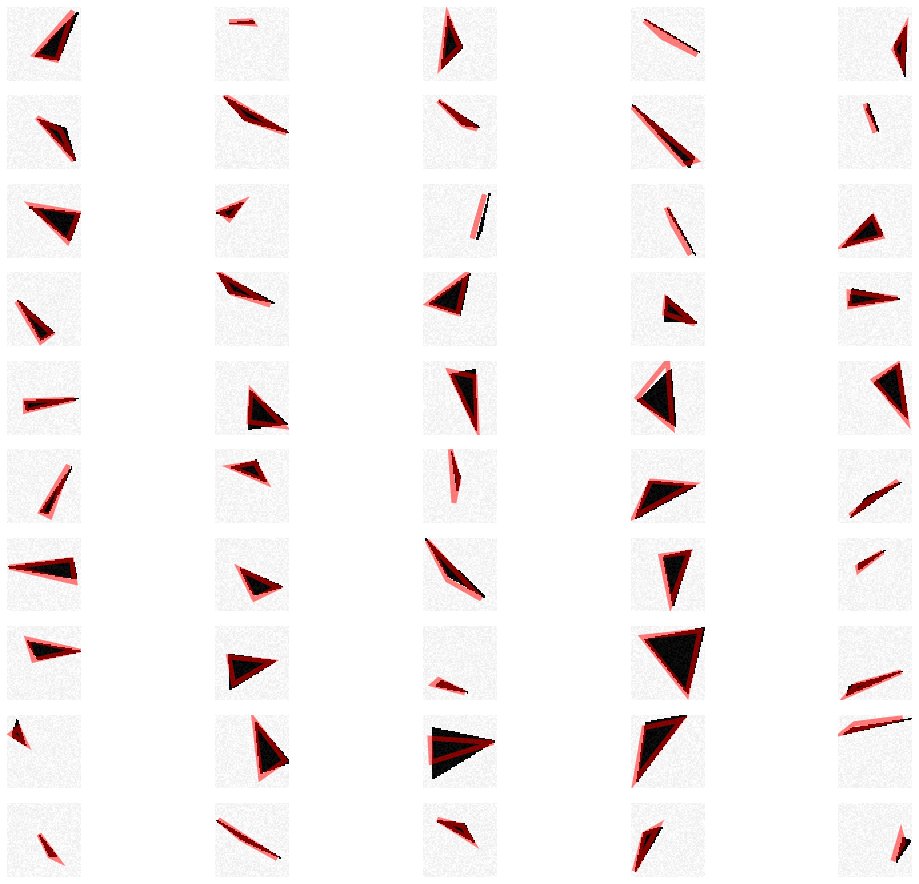

In [35]:
Y_pred=model.predict(X_test)
visualize_prediction(X_test[0:51], Y_pred[0:51],nr=10,nc=5)

## Image Denoising

### A first network

We begin by modifying the required generation functions.

In [0]:
def generate_a_rectangle_star(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return [generate_a_drawing(figsize, U, V, noise), generate_a_drawing(figsize, U, V, 0.0)]

def generate_a_disk_star(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return [generate_a_drawing(figsize, U, V, noise),generate_a_drawing(figsize, U, V, 0.0)]

def generate_a_triangle_star(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [generate_a_drawing(figsize, U, V, noise),generate_a_drawing(figsize, U, V, 0.0)]

def generate_dataset_denoising(nb_samples, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples,im_size])
    print('Creating data:')
    for i in range(nb_samples):
        noise=np.random.uniform(0.0,30.0)
        category = np.random.randint(3)
        if category == 0:
            X[i], Y[i] = generate_a_rectangle_star(noise, free_location)
        elif category == 1: 
            X[i], Y[i] = generate_a_disk_star(noise, free_location)
        else:
            X[i], Y[i] = generate_a_triangle_star(noise, free_location)
    return [X, Y]

def visualise_denoising(x, y, nr):
    fig, axarr = plt.subplots(figsize=(18, 16),nrows=nr,ncols=4)
    index=0
    for i in range(nr):
       # for j in range(4):
        axarr[i,0].imshow(x[index])
        axarr[i,1].imshow(y[index])
        index+=1
        axarr[i,2].imshow(x[index])
        axarr[i,3].imshow(y[index])
        index+=1
    plt.show()

Now we generate some data with our new functions. 

In [37]:
n=5000
X_train2, Y_train2 = generate_dataset_denoising(nb_samples=n, free_location=True)
X_train2 = X_train2.reshape((n,72,72,1))
Y_train2 = Y_train2.reshape((n,72,72,1))                      


Creating data:


We try a simple network first, with only one down sampling, keeping our slow learning adam and with a binary crossentropy loss. While crossentropy is not designed for this problem, since our "colours" are values between zero and one and we want to force the denoising towards one of these extremities, it seems a good natural choice.

In [38]:
#shallow, wide
model = Sequential()
########
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(72,72,1),padding='same',kernel_regularizer=regularizers.l2(0.00001),activity_regularizer=regularizers.l1(0.00001)))
model.add(MaxPooling2D((2,2), padding="same")) #36*36
########
model.add(Conv2D(32,(3,3),padding='same',activation='relu',kernel_regularizer=regularizers.l2(0.00001),activity_regularizer=regularizers.l1(0.00001)))
########
model.add(UpSampling2D((2,2)))
model.add(Conv2D(1,(3,3),activation='sigmoid',padding='same'))
########
model.compile(loss='binary_crossentropy', optimizer=adam)
History=model.fit(X_train2, Y_train2, validation_split=0.03, batch_size=64, epochs=100, verbose=1)

Train on 4850 samples, validate on 150 samples
Epoch 1/100
4850/4850 [==============================] - 4s 838us/step - loss: -2729.7290 - val_loss: -3526.0928
Epoch 2/100
4850/4850 [==============================] - 3s 616us/step - loss: -3560.5768 - val_loss: -3542.5954
Epoch 3/100
4850/4850 [==============================] - 3s 639us/step - loss: -3610.9849 - val_loss: -3583.9809
Epoch 4/100
4850/4850 [==============================] - 3s 638us/step - loss: -3621.5468 - val_loss: -3588.3937
Epoch 5/100
4850/4850 [==============================] - 3s 622us/step - loss: -3627.9683 - val_loss: -3563.9616
Epoch 6/100
4850/4850 [==============================] - 3s 617us/step - loss: -3625.1314 - val_loss: -3581.8327
Epoch 7/100
4850/4850 [==============================] - 3s 616us/step - loss: -3632.1010 - val_loss: -3599.9449
Epoch 8/100
4850/4850 [==============================] - 3s 616us/step - loss: -3641.0191 - val_loss: -3602.9052
Epoch 9/100
4850/4850 [==========================

Plotting the learning rate we can see a good learning profile, and our number of iterations seems reasonable given the tail of the curve.

Text(0.5,1,'Model Performance')

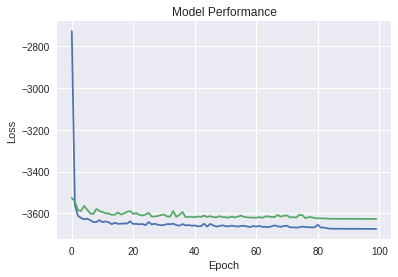

In [39]:
fig, ax = plt.subplots()
#########
ax.plot(History.history['loss'], marker='', label="Train")
ax.plot(History.history['val_loss'], marker='', label="Validation")
########
ax.set_xlabel(r'Epoch')
ax.set_ylabel(r'Loss')
ax.set_title(r'Model Performance')

Generating a test set, and observing the results shows very encouraging denoising, but there are often holes in the edges of the shapes, and the smaller shapes are completely eroded.

Creating data:


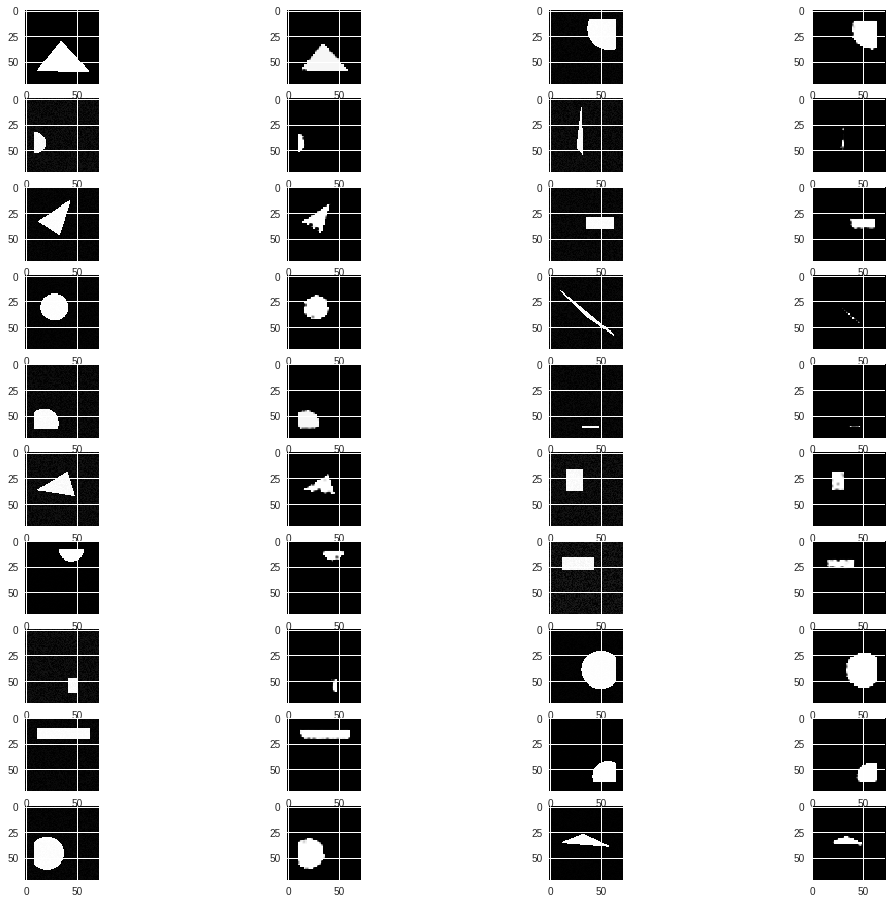

In [40]:
n=20
X_test2, Y_test2 = generate_dataset_denoising(nb_samples=n, free_location=True)
X_test2 = X_test2.reshape((n,72,72,1))
Y_test2 = Y_test2.reshape((n,72,72,1))                      

Y_pred2=model.predict(X_test2)
Y_pred2=Y_pred2.reshape(n,72,72)
X_test2=X_test2.reshape(n,72,72)
visualise_denoising(X_test2,Y_pred2,10)

### A second network

To improve our results and remove these artefacts, we attempt to use a deeper network, more in line with traditional auto-encoders.

In [44]:
model = Sequential()
########
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(72,72,1), strides=(1,1),padding='same',activity_regularizer=regularizers.l1(0.00001)))
model.add(MaxPooling2D((2,2), strides=(2,2), padding="same")) #36*36
########
model.add(Conv2D(32, (3,3), activation='relu',padding='same', strides=(1,1),activity_regularizer=regularizers.l1(0.00001)))
model.add(MaxPooling2D((2,2), strides=(2,2), padding="same")) #18*18
########
model.add(Conv2D(32,(3,3), activation='relu',padding='same', strides=(1,1),activity_regularizer=regularizers.l1(0.00001)))
########
model.add(UpSampling2D((2,2)))
model.add(Conv2D(32,(3,3), activation='relu',padding='same', strides=(1,1),activity_regularizer=regularizers.l1(0.00001)))
########
model.add(UpSampling2D((2,2)))
model.add(Conv2D(1,(3,3),activation='sigmoid',padding='same', strides=(1,1)))
########
model.compile(loss='binary_crossentropy',optimizer=adam)
History=model.fit(X_train2, Y_train2, validation_split=0.06, batch_size=32, epochs=200, verbose=1)

Train on 4700 samples, validate on 300 samples
Epoch 1/200
4700/4700 [==============================] - 6s 1ms/step - loss: -3267.3393 - val_loss: -3575.4596
Epoch 2/200
4700/4700 [==============================] - 4s 942us/step - loss: -3627.5112 - val_loss: -3572.2200
Epoch 3/200
4700/4700 [==============================] - 4s 941us/step - loss: -3608.7236 - val_loss: -3607.1748
Epoch 4/200
4700/4700 [==============================] - 4s 941us/step - loss: -3646.6425 - val_loss: -3611.6684
Epoch 5/200
4700/4700 [==============================] - 4s 941us/step - loss: -3653.6615 - val_loss: -3617.8034
Epoch 6/200
4700/4700 [==============================] - 4s 951us/step - loss: -3653.6429 - val_loss: -3609.4084
Epoch 7/200
4700/4700 [==============================] - 4s 943us/step - loss: -3654.0903 - val_loss: -3624.6089
Epoch 8/200
4700/4700 [==============================] - 4s 943us/step - loss: -3658.1218 - val_loss: -3612.0949
Epoch 9/200
4700/4700 [============================

Plotting the learning rate we see good learning but the network has mostly converged in 25 epochs. 

Text(0.5,1,'Model Perfomance')

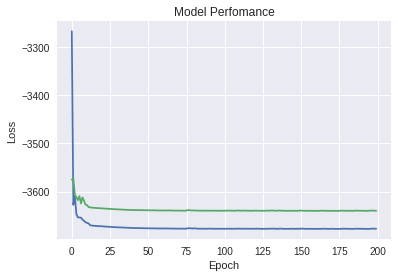

In [45]:
fig, ax = plt.subplots()
#########
ax.plot(History.history['loss'], marker='', label="Train")
ax.plot(History.history['val_loss'], marker='', label="Test")
########
ax.set_xlabel(r'Epoch')
ax.set_ylabel(r'Loss')
ax.set_title(r'Model Perfomance')

The results on actual images are much better and shapes are almost perfectly reconstructed. This is very satisfying. The main failure of our network is on very slim triangles, although it has trouble reconstructing perfect shapes and has a tendancy to round or deform shapes.

Creating data:


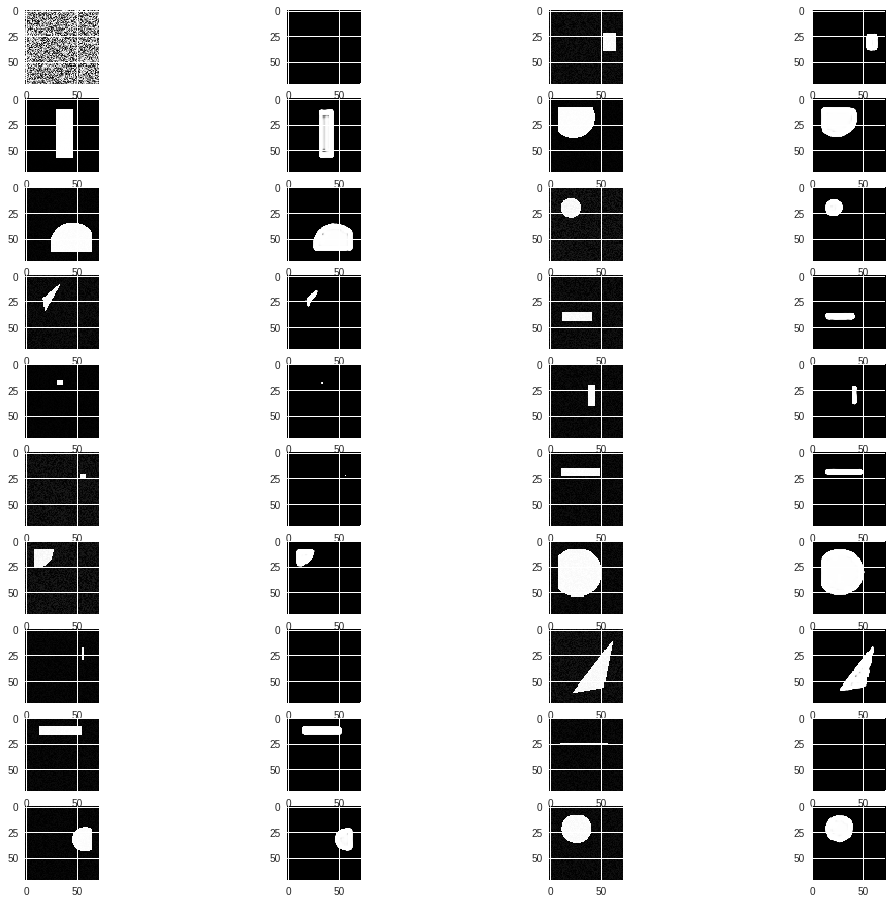

In [46]:
n=20
X_test2, Y_test2 = generate_dataset_denoising(nb_samples=n, free_location=True)
X_test2 = X_test2.reshape((n,72,72,1))
Y_test2 = Y_test2.reshape((n,72,72,1))                      

Y_pred2=model.predict(X_test2)
Y_pred2=Y_pred2.reshape(n,72,72)
X_test2=X_test2.reshape(n,72,72)
visualise_denoising(X_test2,Y_pred2,10)

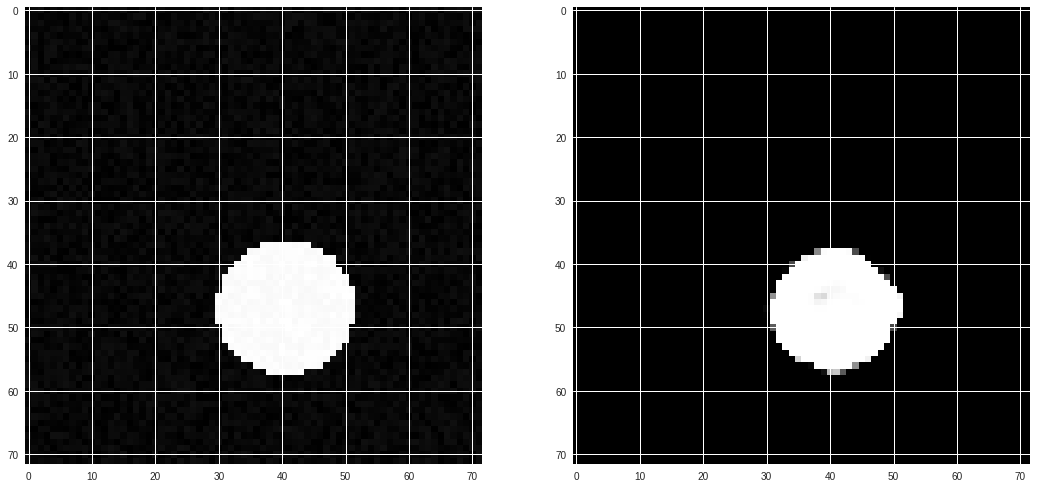

In [0]:
# To visualize one unique pair of images, simply replace 19 by the desired index
fig, (ax1,ax2) = plt.subplots(figsize=(18, 16),nrows=1,ncols=2)
ax1.imshow(X_test2[19])
ax2.imshow(Y_pred2[19])
plt.show()